In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, TensorDataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import truncnorm

import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load the MNIST dataset and split it into the train, eval, and test set

In [3]:
dataset = MNIST(root='./',
                transform=transforms.ToTensor(),
                download=True)


In [4]:
test_set = MNIST(root='./',
                train=False,
                transform=transforms.ToTensor(),
                download=True)

### Visualize data

In [5]:
%matplotlib inline
sns.set()

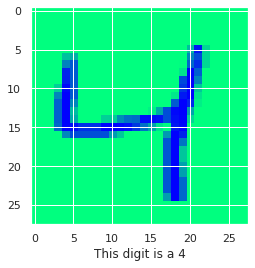

In [6]:
image = dataset[2][0][-1, :, :]
label = dataset[2][1]

plt.imshow(image, cmap='winter_r')
plt.xlabel(f"This digit is a {label}")
plt.show()

In [7]:
dataset[2][1] == 4

True

In [8]:
def binary_targets(dataset):
    """
    Change the targets to binary
    Digit 4 -> 1
    All other digits -> 0
    """
    
    dataset.targets[dataset.targets != 4] = 0
    dataset.targets[dataset.targets == 4] = 1

In [9]:
binary_targets(dataset)
binary_targets(test_set)

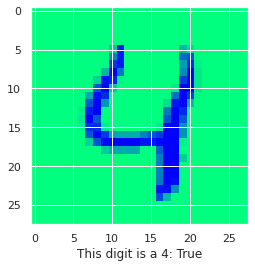

In [10]:
image = test_set[4][0][-1, :, :]
label = bool(test_set[4][1])

plt.imshow(image, cmap='winter_r')
plt.xlabel(f"This digit is a 4: {label}")
plt.show()

The available MNIST dataset does not contain a validation set.
To prevent overfitting, I will create a validation set by slicing 10 000 images from the training set.

In [11]:
train_indices = torch.arange(0, len(dataset)-10000)
val_indices = torch.arange(len(dataset)-10000, len(dataset))
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)

## Create a custom multi-image dataset from MNIST

average 10
images with standard deviation of 3, but no less than 3 and no more than 30.

In [12]:
def create_dataset_shape(size, mean=10, sd=3, low=3, upp=30):
    """
    In: desired dataset size, mean, standard deviation, lower and upper boundary
    Out: tuple of the given size, where each item is a randomly generated sequence length
    """
    
    trunc = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    trunc_array = torch.round(torch.from_numpy(trunc.rvs(size))).int()
    trunc_list = [int(num) for num in trunc_array]
    
    return tuple(trunc_list)

In [13]:
train_shape = create_dataset_shape(4940)
val_shape = create_dataset_shape(960)
test_shape = create_dataset_shape(960)

In [14]:
assert sum(train_shape) <= len(train_set)
assert sum(val_shape) <= len(val_set)
assert sum(test_shape) <= len(test_set)

In [15]:
def split_x_and_y(dataset):
    """
    Split inputs and targets in order to modify them into a custom dataset
    In: torch dataset
    Out: inputs (torch tensor), targets (tuple)
    """

    dataset_x, dataset_y = zip(*dataset)
    dataset_x = torch.stack(list(dataset_x), dim=0)
    dataset_y = torch.tensor(dataset_y)
    return dataset_x, dataset_y

In [16]:
def custom_dataset(inputs, targets, data_shape):
    """
    In: inputs (tensor) and targets (iterable) from existing dataset;
        new desired shape of multi-image dataset
    Out: new inputs (len(shape) x max sequence length x channel x image_dim1 x image_dim2) 
        targets (len(shape))
            
    """
    size_x = (len(data_shape), max(data_shape)) + tuple(inputs[0].shape)
    print(size_x)                                                   
    size_y = (len(data_shape), max(data_shape))
    print(size_y)
    
    x = torch.zeros(size_x)
    y = torch.zeros(size_y)

    line_index = 0

    for idx, dim in enumerate(data_shape):
        x[idx,0:dim] = inputs[line_index: line_index+dim]
        y[idx,0:dim] = targets[line_index: line_index+dim]
        line_index += dim

    y = torch.where(y.sum(axis=1)>=1, 1, 0)
    return x, y

In [17]:
train_x, train_y = split_x_and_y(train_set)
train_x, train_y = custom_dataset(train_x, train_y, train_shape)

(4940, 20, 1, 28, 28)
(4940, 20)


In [18]:
val_x, val_y = split_x_and_y(val_set)
val_x, val_y = custom_dataset(val_x, val_y, val_shape)

(960, 19, 1, 28, 28)
(960, 19)


In [19]:
test_x, test_y = split_x_and_y(test_set)
test_x, test_y = custom_dataset(test_x, test_y, test_shape)

(960, 19, 1, 28, 28)
(960, 19)


In [20]:
train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)
test_dataset = TensorDataset(test_x, test_y)

## Create model

In [21]:
class ImageClassifier(nn.Module):
        
    def __init__(self,
                 input_size,
                 seq_length,
                 dropout_rate,
                 n_outputs,
                 batch_size
                ):
        
        super().__init__()
        
        self.conv1 = nn.Conv2d(1, 64, 4)
        self.conv2 = nn.Conv2d(64, 128, 4)
        self.conv3 = nn.Conv2d(128, 256, 4)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc = nn.Linear(256, n_outputs)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs): 
        x_tmp = inputs.reshape(batch_size*seq_length, 1, input_size, input_size)
        x = self.maxpool(self.relu(self.conv1(x_tmp)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = x.reshape(batch_size, seq_length, 256)
        x = self.dropout(x)
        x = x.mean(dim=1) 
        x = self.fc(x)
        x = self.sigmoid(x)

        return x

#### Hyperparameters

In [22]:
input_size = 28
seq_length = 20
n_outputs = 1
dropout_rate = 0.25
learning_rate = 0.001
batch_size = 64
num_epochs = 6

In [23]:
model = ImageClassifier(
                        input_size=input_size,
                        seq_length=seq_length,
                        dropout_rate=dropout_rate,
                        n_outputs=n_outputs,
                        batch_size=batch_size
                        ).to(device)
print(model)

ImageClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Create data loaders

In [24]:
train_loader = DataLoader(train_dataset, batch_size)
val_loader = DataLoader(val_dataset, batch_size)
test_loader = DataLoader(val_dataset, batch_size)

In [25]:
for i, (inputs, targets)in enumerate(train_loader):
    print(inputs.shape)
    break

torch.Size([64, 20, 1, 28, 28])


## Train model

In [26]:
def train_model(train_loader=train_loader,
                val_loader=val_loader,
                model=model,
                criterion=nn.BCELoss(),
                num_epochs=num_epochs,
                learning_rate=learning_rate
               ):
    
    start_time = time.time()
    
    train_losses = []
    val_losses = []
    accs = []
    val_accs = []
    
    for epoch in range(num_epochs):
        total_loss = 0
        total_loss_val = 0

        model.train()
        
        for inputs, targets in train_loader: 
            inputs = inputs.to(device=device)
            targets = targets.to(device=device)
            
            optimizer= torch.optim.Adam(model.parameters(), lr=learning_rate)
            optimizer.zero_grad()
            
            
            output = model(inputs)
            loss = criterion(output.squeeze(), targets.float())
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

            
        train_losses.append(total_loss/len(train_loader))
        model.eval()
        
        
        for val_inputs, val_labels in val_loader:
            val_output = model(val_inputs)
            val_loss = criterion(val_output.squeeze(), val_labels.float())
            total_loss_val += val_loss.item()
            
            
        val_losses.append(total_loss_val/len(val_loader))
    
        
        print(f"Epoch: {epoch+1}/{ n_epochs}\t",
              f"{((time.time() - start_time) / 60):.2f} min\t",
              f"Loss: {total_loss/len(train_loader):.3f}\t",
              f"Val Loss: {total_loss_val/len(val_loader):.3f}\t")
            
            
    print(f"Training completed in {(time.time() - start_time) / 60} min.")
    
    return train_losses, val_losses

In [27]:
train_losses, val_losses = train_model()

RuntimeError: shape '[1280, 1, 28, 28]' is invalid for input of size 188160

## Test model

## Make predictions